In [1]:
%load_ext autoreload
# %reload_ext autoreload

In [2]:
import os
import pandas as pd
from pycaret.time_series import TSForecastingExperiment
import numpy as np
import matplotlib.pylab as plt
from pycaret.regression import *
from pathlib import Path

In [3]:
%autoreload
import sys
sys.path.append(sys.path[0][0:-4] + 'mikael')
from pipeline import Pipin
pipin = Pipin()

In [4]:
df = pipin.get_combined_datasets(randomize=True)


In [5]:
# can you move the pv_measurment to the end of the df?
pv_measurement = df['pv_measurement']
df = df.drop(columns=['pv_measurement']) 
# add the column to the end of the df
df['pv_measurement'] = pv_measurement
# I want to change the values of location from string to int
mask_a = df['location:idx'] == 'A'
mask_b = df['location:idx'] == 'B'
mask_c = df['location:idx'] == 'C'
df['location:idx'][mask_a] = 0
df['location:idx'][mask_b] = 1
df['location:idx'][mask_c] = 2
df


,time,sfc_pressure:hPa,air_density_2m:kgm3,cloud_base_agl:m,elevation:m,clear_sky_energy_1h:J,total_cloud_cover:p,ceiling_height_agl:m,fresh_snow_6h:cm,pressure_100m:hPa,...,dew_or_rime:idx,is_day:idx,is_in_shadow:idx,precip_type_5min:idx,snow_drift:idx,day_of_year,hour,month,location:idx,pv_measurement
0,2020-05-05 14:00:00,1016.000000,1.25275,1330.500000,7.0,2.184809e+06,99.724998,1292.199951,0.0,1003.750000,...,0.0,1.0,0.0,0.0,0.0,126,14,5,1,305.325
1,2020-06-03 03:00:00,1014.450012,1.23775,259.100006,6.0,1.863219e+05,100.000000,349.924988,0.0,1002.325012,...,0.0,1.0,0.0,0.0,0.0,155,3,6,0,30.580
2,2021-09-21 11:00:00,1012.400024,1.22250,1120.800049,24.0,1.622001e+06,99.474998,2558.600098,0.0,1000.375000,...,0.0,1.0,0.0,0.0,0.0,264,11,9,2,245.000
3,2021-05-23 19:00:00,1001.799988,1.21925,1951.550049,24.0,3.200152e+05,95.500000,6259.950195,0.0,989.849976,...,0.0,1.0,0.0,0.0,0.0,143,19,5,2,19.600
4,2022-11-05 10:00:00,1000.500000,1.22500,942.250000,6.0,4.092977e+05,86.550003,6432.700195,0.0,988.500000,...,0.0,1.0,0.0,0.0,0.0,309,10,11,0,667.480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93018,2020-08-16 19:00:00,1015.224976,1.22900,1016.700012,24.0,7.448845e+04,1.600000,NaN,0.0,1003.200012,...,0.0,0.0,1.0,0.0,0.0,229,19,8,2,0.000
93019,2022-05-18 06:00:00,1019.650024,1.24975,6050.075195,6.0,1.198274e+06,69.400002,7335.075195,0.0,1007.400024,...,0.0,1.0,0.0,0.0,0.0,138,6,5,0,2282.720
93020,2021-10-31 02:00:00,993.075012,1.21725,333.149994,24.0,0.000000e+00,100.000000,4034.949951,0.0,981.174988,...,0.0,0.0,1.0,1.0,0.0,304,2,10,2,0.000
93021,2022-05-12 00:00:00,992.099976,1.22900,1172.250000,6.0,0.000000e+00,100.000000,1654.425049,0.0,980.099976,...,1.0,0.0,1.0,1.0,0.0,132,0,5,0,0.000


In [6]:
to_ignore = [
    # "elevation:m"
    ]
keepers = [
"time",
"clear_sky_energy_1h:J",
"visibility:m",
"air_density_2m:kgm3",
"direct_rad_1h:J",
"date_calc",
"ceiling_height_agl:m",
"msl_pressure:hPa",
"pressure_100m:hPa",
"sfc_pressure:hPa",
"pressure_50m:hPa",
"sun_elevation:d",
"effective_cloud_cover:p",
"sun_azimuth:d",
"relative_humidity_1000hPa:p",
"cloud_base_agl:m",
"diffuse_rad:W",
"dew_point_2m:K",
"absolute_humidity_2m:gm3",
"precip_5min:mm",
"direct_rad:W",
"diffuse_rad_1h:J",
"prob_rime:p",
"t_1000hPa:K",
"clear_sky_rad:W",
"total_cloud_cover:p",
# "elevation:m",
"dew_or_rime:idx",
"is_day:idx",
"is_in_shadow:idx",
"day_of_year",
"hour",
"month",
"year",
"pv_measurement",
"location:idx",
]


# add rest of name from df columns
for col in df.columns:
    if col not in keepers:
        to_ignore.append(col)

In [7]:
categorical_features = []
for feat in pipin.get_categorical_features(df):
    # if feat not in to_ignore:
    if feat not in to_ignore and feat != "location:idx":
        categorical_features.append(feat)
# print(to_ignore)

In [8]:
ignore_features = pipin.get_irrelevant_features()
s = setup(df, target="pv_measurement", normalize=True, categorical_features=categorical_features, experiment_name="pv_power_mw", ignore_features=ignore_features, index=False)

,Description,Value
0,Session id,835
1,Target,pv_measurement
2,Target type,Regression
3,Original data shape,"(93023, 52)"
4,Transformed data shape,"(93023, 51)"
5,Transformed train set shape,"(65116, 51)"
6,Transformed test set shape,"(27907, 51)"
7,Ignore features,4
8,Ordinal features,2
9,Numeric features,45


In [9]:
lightgbm = s.create_model('lightgbm')
# lightgbm = s.create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,90.6992,66747.5762,258.3555,0.8908,1.4606,1.4262
1,89.1351,63976.6488,252.9361,0.8981,1.4839,1.3537
2,94.5349,75710.8014,275.1560,0.8771,1.4473,1.3927
3,83.0211,54903.3258,234.3146,0.9017,1.4727,1.3588
4,90.4198,63038.4902,251.0747,0.8948,1.4647,2.1622
5,92.0041,67298.1853,259.4189,0.8886,1.4342,1.4802
6,87.7537,64690.9228,254.3441,0.8846,1.5086,1.4111
7,88.5157,64168.8257,253.3157,0.8850,1.4692,1.3453
8,87.2949,65775.9692,256.4683,0.8830,1.4680,1.8366


In [10]:
tuned = s.tune_model(lightgbm, optimize="MAE")
# final_gbm= s.finalize_model(lightgbm)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:14:05
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,80.7473,57548.5462,239.8928,0.9059,1.2499,1.2539
1,81.8806,56799.5578,238.3266,0.9096,1.3061,1.2328
2,83.6034,62827.2752,250.6537,0.8980,1.2521,1.4576
3,76.4354,48419.6528,220.0447,0.9133,1.2666,1.4455
4,82.8910,56817.8847,238.3650,0.9051,1.2877,1.9745
5,81.7467,56650.8293,238.0143,0.9062,1.2717,1.4610
6,79.2695,52796.7180,229.7754,0.9058,1.2754,1.3174
7,79.3598,55165.0069,234.8723,0.9011,1.2917,1.4150
8,78.6186,54429.3541,233.3010,0.9031,1.2846,1.5513


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [11]:
gump = s.create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,85.8817,65275.2255,255.4902,0.8932,0.9088,1.1081
1,84.3645,63158.5105,251.3136,0.8994,0.9145,1.1379
2,87.2988,72103.5073,268.5210,0.8829,0.8941,1.2942
3,78.8644,55573.1250,235.7395,0.9005,0.9081,1.3410
4,86.1211,64125.3619,253.2299,0.8929,0.8864,1.7609
5,85.6339,66895.1517,258.6410,0.8893,0.8721,1.4175
6,83.7962,65576.3058,256.0787,0.8830,0.8907,1.4118
7,82.4210,62877.5120,250.7539,0.8873,0.9019,1.0940
8,83.5012,67839.4619,260.4601,0.8793,0.8809,1.3883


In [20]:
# tuned_gump = s.tune_model(gump, optimize="MAE")
# final_gump = s.finalize_model(tuned_gump)
# final_gump = s.finalize_model(gump)

In [ ]:
# rf
# random = s.create_model('rf')
# tuned_random = s.tune_model(random)
# final_random = s.finalize_model(tuned_random)
# final_random = s.finalize_model(random)

In [13]:
stacker = stack_models([lightgbm, gump], meta_model=lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,81.7638,59183.7102,243.2770,0.9032,1.0448,1.0056
1,81.0096,58427.0929,241.7170,0.9070,0.9954,1.0278
2,84.6533,67886.5939,260.5506,0.8898,1.0189,1.1154
3,75.5991,51367.1012,226.6431,0.9080,1.0388,1.1547
4,82.1372,58208.1373,241.2636,0.9028,1.0188,1.4959
5,82.8419,61564.6453,248.1222,0.8981,1.0207,1.2145
6,81.1839,60686.2661,246.3458,0.8917,1.0231,1.2262
7,79.7348,59274.7875,243.4641,0.8938,1.0287,0.9705
8,78.3009,60310.9940,245.5830,0.8927,1.0035,1.1341


In [14]:
final_stack = finalize_model(stacker)

In [22]:
# evaluate_model(lightgbm)

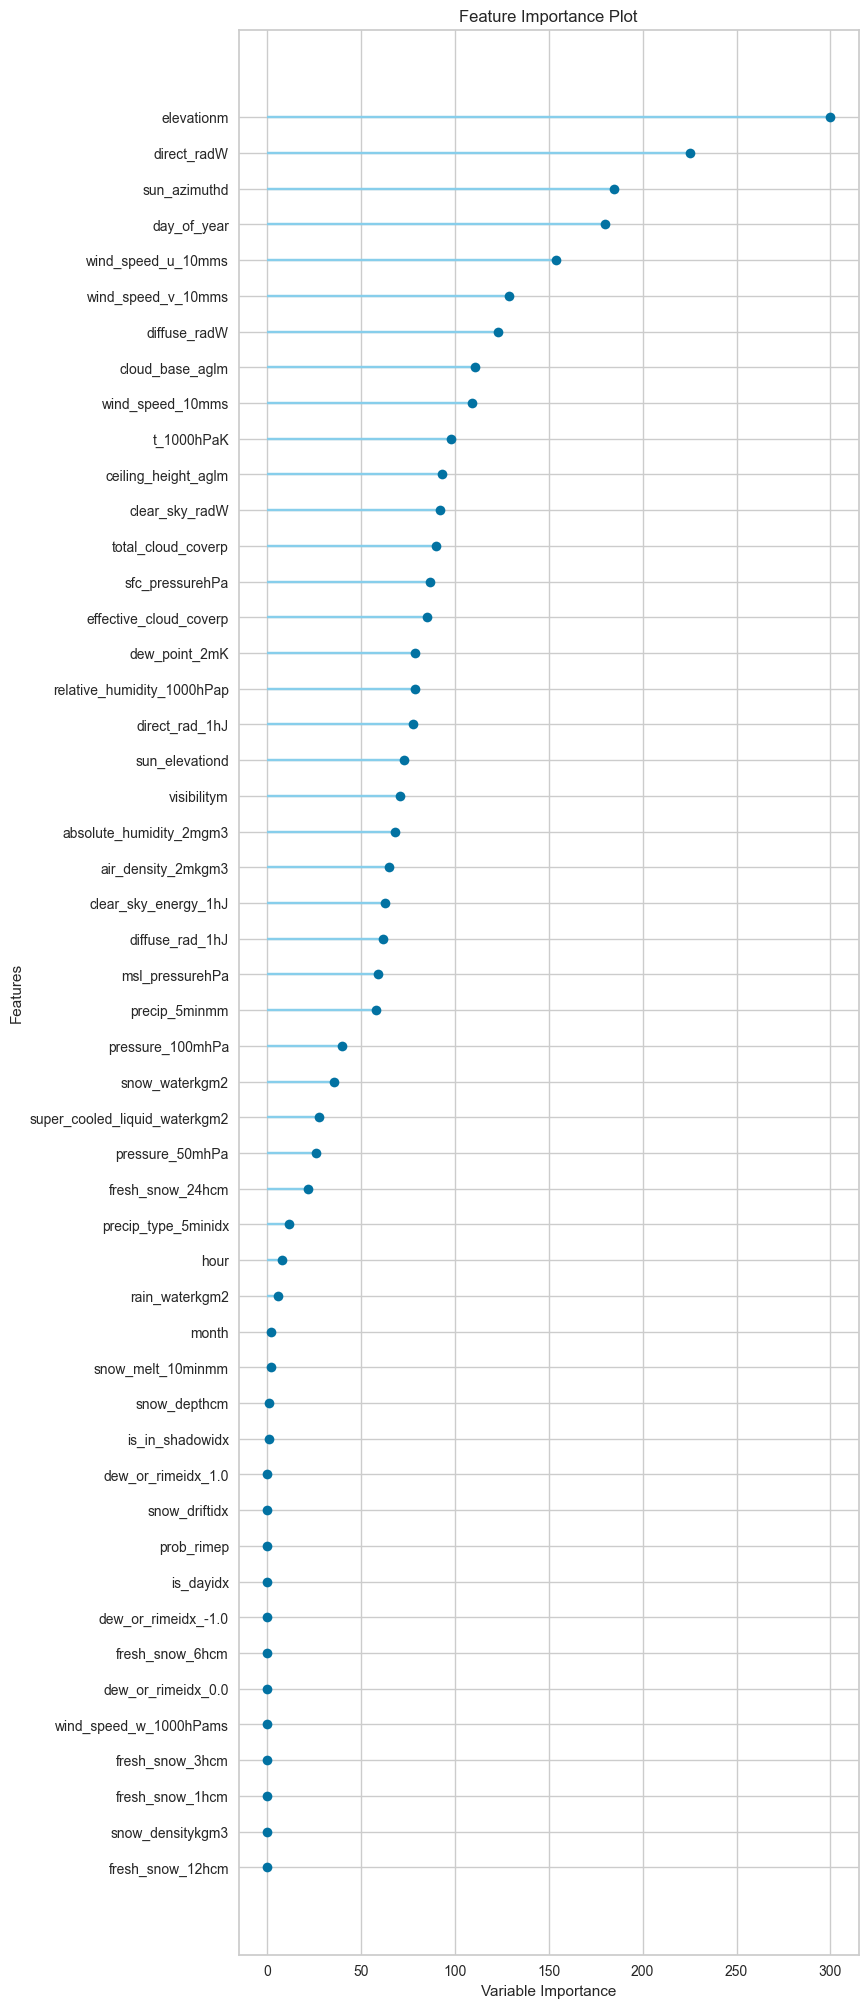

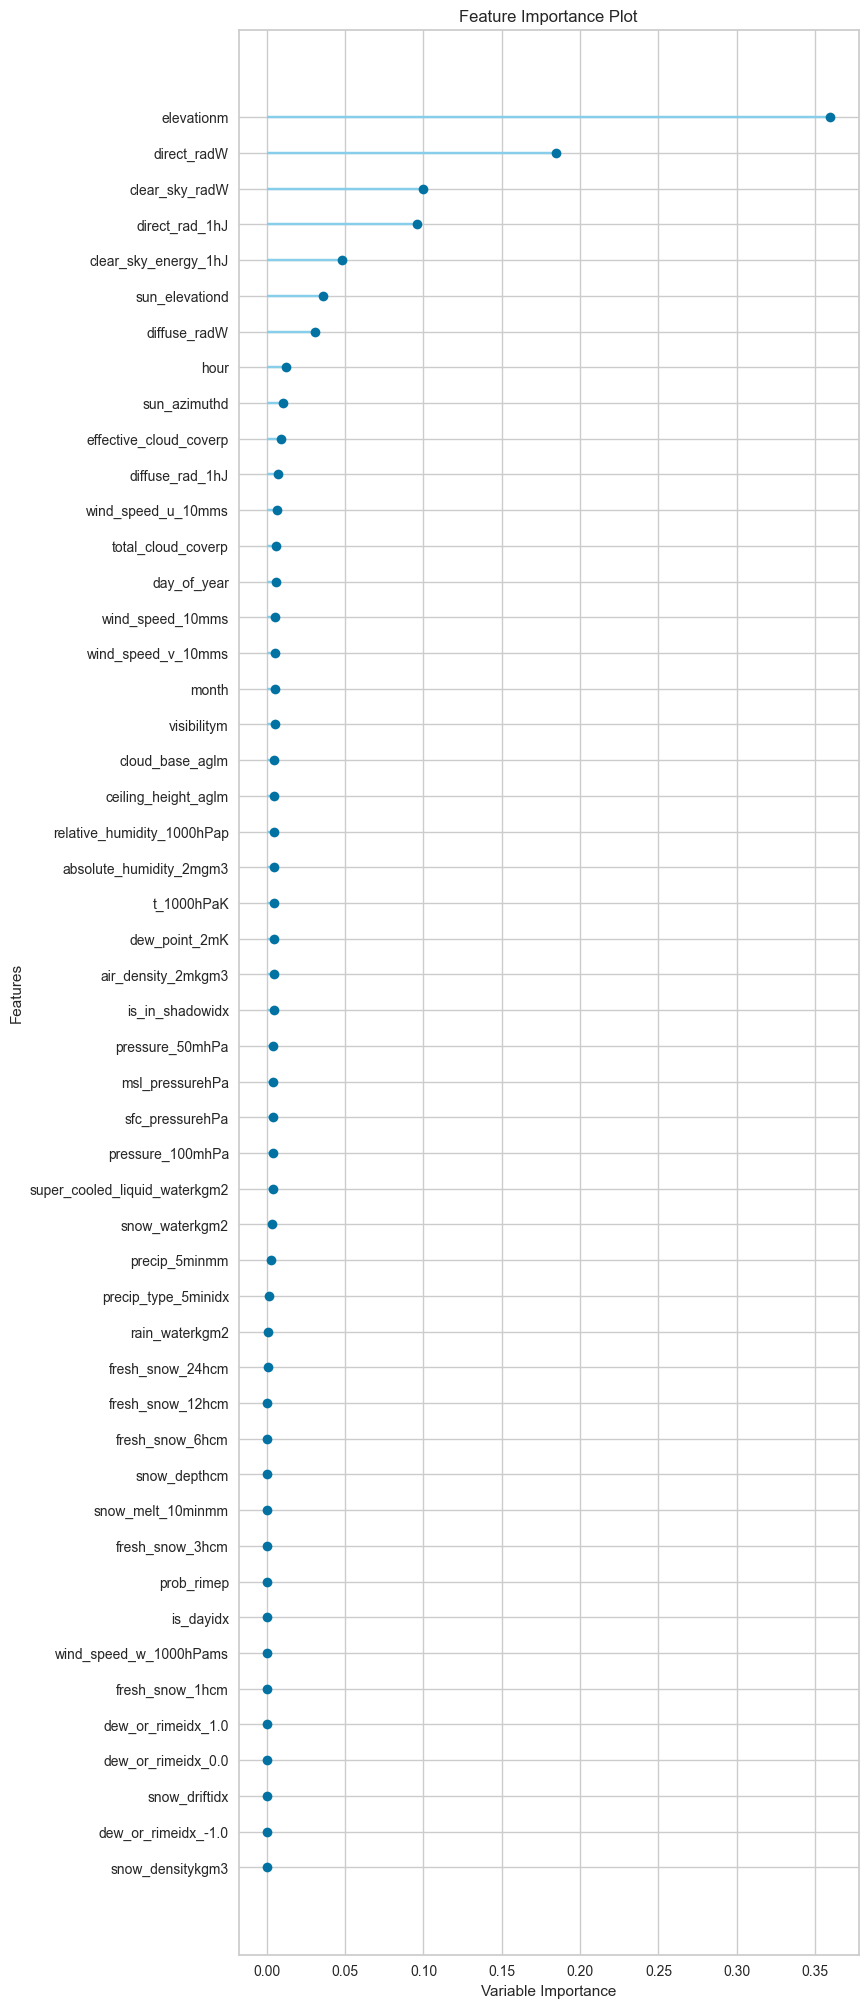

In [24]:
plot_model(lightgbm, plot="feature_all")
plot_model(gump, plot="feature_all")

# for col in df.columns:
#         print(col)

In [ ]:
# import numpy as np
# importances = lightgbm.feature_importances_
# importances_name = lightgbm.feature_name_


# importances_dict = {feature: importance for feature, importance in zip(importances_name, importances)}
# sorted_importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)

# for feature, importance in sorted_importances:
#     print(f"{feature}: {importance}")

In [ ]:
# gump = s.create_model('et')
# s.finalize_model(gump)

In [16]:
test_data = pipin.get_combined_test_data()
# test_data = pipin.get_test_data("A")

In [17]:

def get_unique_filename(base_name, folder = "submissions"):
    end = ""
    if folder == "models":
        end = ".pkl"
    
    file_path = Path(folder) / f"{base_name}.csv{end}"
    count = 1
    while file_path.exists():
        file_path = Path(folder) / f"{base_name}_{count}.csv{end}"
        count += 1
    return str(file_path)

In [ ]:
# res_gump = predict_model(gump, test_data)
# res_gump= res_gump[["prediction_label"]].rename(columns={"prediction_label": "prediction"}).rename_axis(index="id")
# res_gump.to_csv(get_unique_filename("gump"), header=True)

In [18]:
# res_goose = predict_model(lightgbm, test_data)
res_stack = predict_model(stacker, test_data)
res_stack = res_stack[["prediction_label"]].rename(columns={"prediction_label": "prediction"}).rename_axis(index="id")
# res_stack.to_csv(get_unique_filename('sub'))
# save_model(final_stack, model_name=get_unique_filename('stack_gbm_et', "models"))


In [19]:
print("done", res_stack.shape)
pipin.compare_mae(res_stack)


done (2160, 1)


63.09029505297623